# Security Prediction Problem

In [1]:
# Primero importamos las librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM, BatchNormalization
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import SpatialDropout1D
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import string
from wordcloud import WordCloud
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from keras.callbacks import EarlyStopping

%matplotlib inline

Using TensorFlow backend.


#### El archivo original es el siguiente

In [2]:
df = pd.read_excel("Gisell.xlsx")

In [3]:
df.head()

,Renaissance,Antagonismo,Intensidad,Text
0,0.0,Nacional,2,"El TLC no sirvió, a México lo incrustaron, ni ..."
1,0.0,Público,2,"Hay más de 80 millones de pobres, se exportan ..."
2,0.0,Nacional,3,"Cedimos la banca nacional, no puedes competir ..."
3,0.0,Interior,2,"No está fluyendo el dinero, se dice que tienen..."
4,0.0,Público,1,Las cajas de ahorro (casi 500) las había cread...


> **"Renaissance"** es una variable binaria propuesta para una futura variable de Seguridad donde ayude a la sinergia de las variables **"Antagonismo"** e **"Intensidad"**.

> **"Antagonismo"**: Contiene la clasificación de las amenazas a analizar.

> **"Intensidad"**: Representa el grado de amenaza de cada una de las variantes de la variable antagónica.

> **"Text"**: Declaraciones de diversas fuentes y la variable independiente a analizar.

Se creará una nueva variable: **"Security"** y se eliminará la variable binaria.

In [5]:
df.drop("Renaissance", axis=1, inplace=True)

In [6]:
df.head()

,Antagonismo,Intensidad,Text
0,Nacional,2,"El TLC no sirvió, a México lo incrustaron, ni ..."
1,Público,2,"Hay más de 80 millones de pobres, se exportan ..."
2,Nacional,3,"Cedimos la banca nacional, no puedes competir ..."
3,Interior,2,"No está fluyendo el dinero, se dice que tienen..."
4,Público,1,Las cajas de ahorro (casi 500) las había cread...


In [7]:
conditions = [
    (df["Antagonismo"] == "Nacional") & (df["Intensidad"] == 3),
    (df["Antagonismo"] == "Nacional") & (df["Intensidad"] == 2),
    (df["Antagonismo"] == "Nacional") & (df["Intensidad"] == 1),
    (df["Antagonismo"] == "Interior") & (df["Intensidad"] == 3),
    (df["Antagonismo"] == "Interior") & (df["Intensidad"] == 2),
    (df["Antagonismo"] == "Interior") & (df["Intensidad"] == 1),
    (df["Antagonismo"] == "Público") & (df["Intensidad"] == 3),
    (df["Antagonismo"] == "Público") & (df["Intensidad"] == 2),
    (df["Antagonismo"] == "Público") & (df["Intensidad"] == 1)
]
# cambiando valores
values = [9,8,7,6,5,4,3,2,1]

In [8]:
df["Security"] = np.select(conditions, values)

In [9]:
df.head()

,Antagonismo,Intensidad,Text,Security
0,Nacional,2,"El TLC no sirvió, a México lo incrustaron, ni ...",8
1,Público,2,"Hay más de 80 millones de pobres, se exportan ...",2
2,Nacional,3,"Cedimos la banca nacional, no puedes competir ...",9
3,Interior,2,"No está fluyendo el dinero, se dice que tienen...",5
4,Público,1,Las cajas de ahorro (casi 500) las había cread...,1


In [11]:
# Numero de ejemplos en cada una de las clasificaciones.
df["Security"].value_counts()

8    196
7    153
9     76
6     68
5     53
4     11
3      8
2      8
0      4
1      3
Name: Security, dtype: int64

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 580 entries, 0 to 579
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Antagonismo  580 non-null    object
 1   Intensidad   580 non-null    int64 
 2   Text         580 non-null    object
 3   Security     580 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 18.2+ KB


In [ ]:
# Guardamos el archivo en formato CSV
df.to_csv("Gisell.csv", index=False)

## Importamos el archivo nuevo y preparamos el texto.

In [13]:
df = pd.read_csv("Gisell.csv")

In [14]:
df.head()

,Antagonismo,Intensidad,Text,Security
0,Nacional,2,"El TLC no sirvió, a México lo incrustaron, ni ...",8
1,Público,2,"Hay más de 80 millones de pobres, se exportan ...",2
2,Nacional,3,"Cedimos la banca nacional, no puedes competir ...",9
3,Interior,2,"No está fluyendo el dinero, se dice que tienen...",5
4,Público,1,Las cajas de ahorro (casi 500) las había cread...,1


### Ya que el modelo no puede recbir datos no estructurados es necesario encontrar una representación de las palabras en un espacio vectorial correcto para su manipulación, es decir, que el texto mantenga sus características  en una representación numérica

In [15]:
def create_corpus(df, target):
    corpus = []
    for i in df[df["Renaissance"] == target].Text.str.split():
        for j in i:
            corpus.append(j)
    return corpus

# Removing punctuation
def remove_punct(text):
    table = str.maketrans("", "", string.punctuation)
    return text.translate(table)

# Removing the stopwords
def remove_stopwords(text):
    text = [word.lower() for word in text.split() if word.lower() not in stop]
    return " ".join(text)

def lematizer(text):
    text = [wordnet.lemmatize(word) for word in text.split()]
    return " ".join(text)

In [16]:
df["Text"] = df["Text"].map(remove_punct)

In [18]:
df["Text"] = df["Text"].map(lambda x: x.lower())

In [22]:
wordnet = WordNetLemmatizer()
corpus = []
# In this case we preserve the stop words since the statements in the Text don't have the length of a full article
df["Text"] = df.Text.apply(lematizer)

> Debido a que los datos no están balanceados se añadirá una nueva variable que representará un peso adicional en el modelo, este peso dependerá de la cantidad de elementos existentes en cada clasificación.

In [24]:
from sklearn.utils import class_weight

In [25]:
class_weights = list(class_weight.compute_class_weight('balanced',
                                                       np.unique(df["Security"]),
                                                       df["Security"]))

In [26]:
class_weights

[16.11111111111111,
 8.055555555555555,
 8.055555555555555,
 5.858585858585859,
 1.1934156378600822,
 0.9477124183006536,
 0.4212055192447349,
 0.3254769921436588,
 0.847953216374269]

In [27]:
weights = {1: 16.11111111111111,
           2: 8.055555555555555,
           3: 8.055555555555555,
           4: 5.858585858585859,
           5: 1.1934156378600822,
           6: 0.9477124183006536,
           9: 0.4212055192447349,
           7: 0.3254769921436588,
           8: 0.847953216374269}

In [28]:
df["Weights"] = df["Security"].map(weights)

In [29]:
df.head()

,Antagonismo,Intensidad,Text,Security,Weights
0,Nacional,2,el tlc no sirvió a méxico lo incrustaron ni si...,8,0.847953
1,Público,2,hay más de 80 millones de pobres se exportan 3...,2,8.055556
2,Nacional,3,cedimos la banca nacional no puedes competir s...,9,0.421206
3,Interior,2,no está fluyendo el dinero se dice que tienen ...,5,1.193416
4,Público,1,la cajas de ahorro casi 500 la había creado ad...,1,16.111111


## Creación del cuerpo textual
Se refiere a la integración de todo el texto en una estructura de datos que funcionará como los datos de entrenmiento

In [30]:
X = df.drop(["Antagonismo", "Intensidad", "Security"], axis=1)
y = df["Security"]

In [31]:
X.head()

,Text,Weights
0,el tlc no sirvió a méxico lo incrustaron ni si...,0.847953
1,hay más de 80 millones de pobres se exportan 3...,8.055556
2,cedimos la banca nacional no puedes competir s...,0.421206
3,no está fluyendo el dinero se dice que tienen ...,1.193416
4,la cajas de ahorro casi 500 la había creado ad...,16.111111


In [34]:
y.unique()

array([8, 2, 9, 5, 1, 7, 6, 4, 3])

In [35]:
for i in range(0, X.shape[0]):
    corpus.append(X["Text"][i])

In [36]:
corpus[0:15]

['el tlc no sirvió a méxico lo incrustaron ni siquiera lo consultaron',
 'hay más de 80 millones de pobres se exportan 30 millones de mexicano por que no hay trabajo',
 'cedimos la banca nacional no puedes competir si no tienes banca el 92 de la banca e extranjera brasil y china le deben su éxito a que su banca en nacional',
 'no está fluyendo el dinero se dice que tienen 180 billones de dólares de reserva pero no se están usando',
 'la cajas de ahorro casi 500 la había creado adriana salina de gortari y quebraron',
 'luego no metieron al aspan asociación de prosperidad y seguridad de norte américa que hizo fox a espaldas de la nación',
 'estamos en un momento sumamente militar',
 'con trump y su política proteccionista ya de facto dice que el modelo neoliberal está muerto',
 'existe una globalización digital que está sustituyendo la globalización mercantilista y la globalización financiera',
 'pareciera que no existen instrumentos ciudadanos de cogobierno en el siglo xxi e decir no po

In [38]:
# Tamaño del vocabulario
voc_size = 5_000
# Representación en 1's y 0's de cada palabra
onehot_repr = [one_hot(words,voc_size)for words in corpus] 
onehot_repr[0]

[2119, 1505, 2171, 4142, 3541, 349, 1765, 3218, 4277, 4379, 1765, 1790]

> **Este último vector es el índice de cada palabra de la primera oración de cuerpo textual.**

In [39]:
sent_length = 60
embedded_docs = pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
embedded_docs[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0, 2119, 1505, 2171, 4142, 3541,  349, 1765,
       3218, 4277, 4379, 1765, 1790], dtype=int32)

> **Como cada oración es de diferente longitud extenderemos la capacidad del modelo a 60 palabras de manera que cada oración debe de tener la misma longitud y si no la tiene se completará con ceros.**

In [40]:
embedded_docs.shape

(580, 60)

In [41]:
embedded_docs_2 = np.zeros((580, 61))

In [42]:
for i in range(embedded_docs.shape[0]):
    embedded_docs_2[i] = np.append(embedded_docs[i], df["Weights"][i])

In [43]:
embedded_docs_2[0]

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.11900000e+03, 1.50500000e+03, 2.17100000e+03, 4.14200000e+03,
       3.54100000e+03, 3.49000000e+02, 1.76500000e+03, 3.21800000e+03,
      

In [44]:
embedded_docs_2.shape

(580, 61)

In [46]:
y = pd.get_dummies(y)
y.head()

,1,2,3,4,5,6,7,8,9
0,0,0,0,0,0,0,0,1,0
1,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1
3,0,0,0,0,1,0,0,0,0
4,1,0,0,0,0,0,0,0,0


In [47]:
X_train, X_test, y_train, y_test = train_test_split(embedded_docs_2, y.values, test_size = 0.10, random_state = 42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(522, 61) (522, 9)
(58, 61) (58, 9)


In [48]:
X_train.shape

(522, 61)

In [49]:
weight_array = np.zeros(X_train.shape[0])

In [50]:
len(weight_array)

522

In [51]:
X_train_f = np.zeros((522, 60))

In [52]:
for i in range(X_train.shape[0]):
    weight_array[i] = X_train[i][-1]
    X_train_f[i] = X_train[i][:-1]

In [53]:
X_train_f.shape

(522, 60)

In [54]:
weight_array[0:6]

array([0.94771242, 0.94771242, 0.84795322, 0.84795322, 1.19341564,
       0.84795322])

In [55]:
len(weight_array)

522

In [56]:
X_test.shape

(58, 61)

In [57]:
X_test_f = np.zeros((58, 60))

In [58]:
for i in range(X_test.shape[0]):
    X_test_f[i] = X_test[i][:-1]

In [59]:
X_test_f.shape

(58, 60)

In [60]:
print(X_train_f.shape, y_train.shape)
print(X_test_f.shape, y_test.shape)

(522, 60) (522, 9)
(58, 60) (58, 9)


## Recurrent Neural Net

Ya que se está analizando texto la secuencia de las palabras es importante para el entendimiento del significado en el mensaje por lo tanto una red neuronal convencional no basta ya que le daría el mismo peso a todas las palabras, es decir, un 'pero' estaría al nivel de 'guerra', por lo tanto, la arquitectura sera de una red neuronal recurrente con celdas memoria bidireccional, su principal característica es que podrá recordar el principio de la oración y adelantarse a la secuencia de palabras en la oración para entender mejor su significado:

![LSTM](Gisell_LSTM.png)

> **La red representará al texto de entrada en 100 dimensiones, la capa de red consistirá de 128 celdas de memoria y una salida de 9 opciones que dará la probabilidad para cada una de las 9 clasificaciones que tenemos, seleccionando la de mayor probabilidad.**

> **Una característica adicional que asegurará la estabilidad de la red es una capa de Normalización por lo que el conjunto de datos de entrada tendrán las mismas dimensiones.**

In [61]:
embedding_vector_features = 100
model = Sequential()
model.add(Embedding(voc_size, embedding_vector_features,input_length=sent_length))
model.add(BatchNormalization(input_shape=(60, 100)))
model.add(LSTM(128, activation='relu'))
model.add(Dense(9,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 60, 100)           500000    
_________________________________________________________________
batch_normalization (BatchNo (None, 60, 100)           400       
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 9)                 1161      
Total params: 618,809
Trainable params: 618,609
Non-trainable params: 200
_________________________________________________________________
None


In [62]:
history = model.fit(X_train_f, y_train, sample_weight=weight_array, validation_split=0.2, epochs=50, batch_size=25)

Epoch 1/50
17/17 [==============================] - 2s 60ms/step - loss: 2.4850 - accuracy: 0.1766 - val_loss: 2.0858 - val_accuracy: 0.3048
Epoch 2/50
17/17 [==============================] - 1s 41ms/step - loss: 1.8149 - accuracy: 0.3790 - val_loss: 2.0809 - val_accuracy: 0.3238
Epoch 3/50
17/17 [==============================] - 1s 42ms/step - loss: 1.3738 - accuracy: 0.4637 - val_loss: 2.0862 - val_accuracy: 0.2857
Epoch 4/50
17/17 [==============================] - 1s 43ms/step - loss: 0.7356 - accuracy: 0.7296 - val_loss: 2.0855 - val_accuracy: 0.3619
Epoch 5/50
17/17 [==============================] - 1s 41ms/step - loss: 0.5136 - accuracy: 0.8758 - val_loss: 2.0790 - val_accuracy: 0.3238
Epoch 6/50
17/17 [==============================] - 1s 40ms/step - loss: 0.4084 - accuracy: 0.8976 - val_loss: 2.0753 - val_accuracy: 0.3429
Epoch 7/50
17/17 [==============================] - 1s 40ms/step - loss: 0.1695 - accuracy: 0.9297 - val_loss: 2.0734 - val_accuracy: 0.2857
Epoch 8/50
17

In [63]:
a = model.evaluate(X_test_f, y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(a[0], a[1]))

2/2 [==============================] - 0s 13ms/step - loss: 2.1675 - accuracy: 0.3621
Test set
  Loss: 2.168
  Accuracy: 0.362


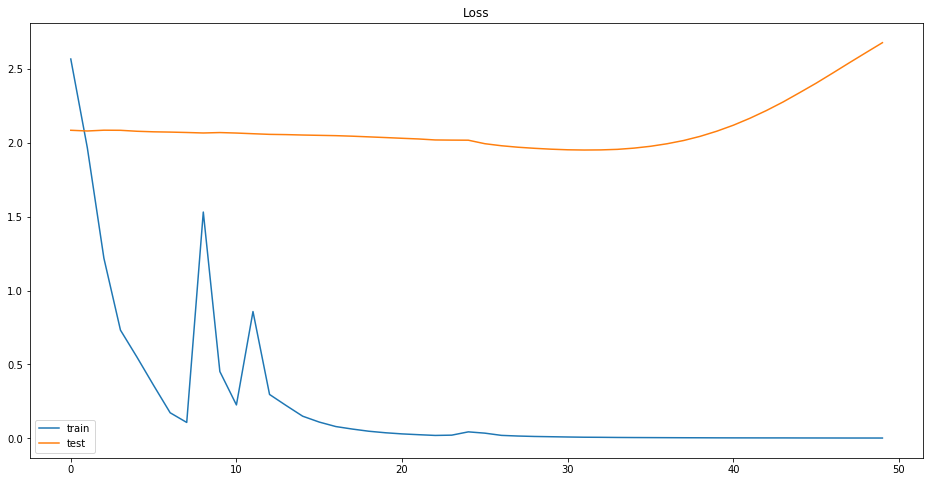

In [64]:
plt.figure(figsize=(16,8))
plt.title("Loss")
plt.plot(history.history["loss"], label='train')
plt.plot(history.history["val_loss"], label='test')
plt.legend()
plt.show()

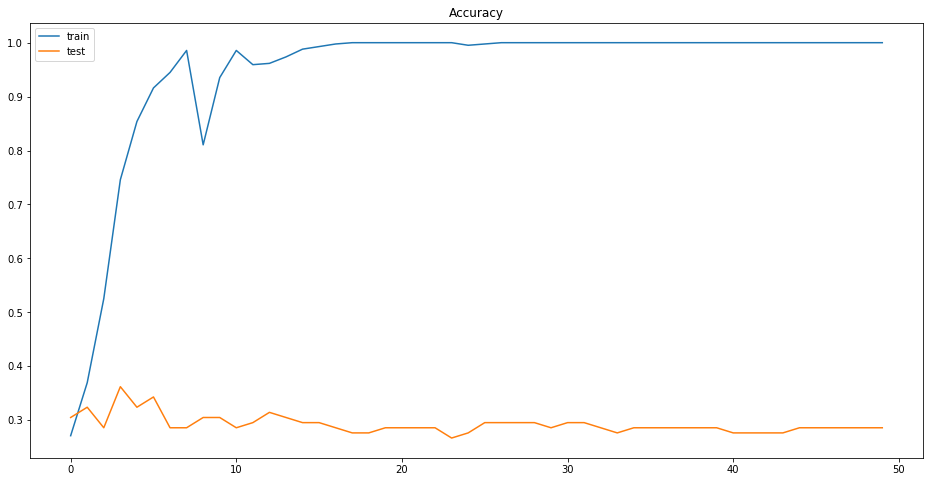

In [65]:
plt.figure(figsize=(16,8))
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

## Evaluando el modelo con nuevos ejemplos
Los siguientes ejemplos se evaluaran al modelo ya entrenado:

1. "El siguiente año el bitcoin va a seguir subiendo"
2. "México entra en un nacionalismo puro"
3. "2021 será el año de la inflación real"

In [69]:
def preprocess_statement(text):
    statement = remove_punct(text)
    statement = statement.lower()
    statement = lematizer(statement)
    statement = one_hot(statement, voc_size)
    statement = pad_sequences([statement], padding='pre', maxlen=sent_length)
    return statement

In [67]:
labels = ["Desafío en Seguridad Pública", 
          "Seguridad Pública en Riego o Amenaza",
          "Seguridad Pública en Crisis",
          "Desafío en Seguridad Interior",
          "Seguridad Interior en Riesgo o Amenaza",
          "Seguridad Interior en Crisis",
          "Defensa Nacional Interna en Desafío",
          "Defensa Nacional Interna en Riesgo o Amenaza",
          "Defensa Exterior"]

In [71]:
pred = model.predict(preprocess_statement("México entra en un nacionalismo puro"))
print(pred, labels[np.argmax(pred)])

[[0.07318199 0.10483803 0.04745098 0.08291679 0.16890422 0.25208563
  0.07977648 0.07560528 0.11524067]] Seguridad Interior en Crisis


In [72]:
pred = model.predict(preprocess_statement("2021 será el año de la inflación real"))
print(pred, labels[np.argmax(pred)])

[[0.0093568  0.0134418  0.01216502 0.01291563 0.04201059 0.02837591
  0.05703839 0.7209323  0.10376362]] Defensa Nacional Interna en Riesgo o Amenaza


In [73]:
pred = model.predict(preprocess_statement("Uno de los funcionarios que firmó el pacto por México sigue activo"))
print(pred, labels[np.argmax(pred)])

[[0.00679701 0.03423879 0.02290665 0.01804313 0.46763805 0.03423718
  0.01754331 0.1854743  0.21312161]] Seguridad Interior en Riesgo o Amenaza


In [74]:
pred = model.predict(preprocess_statement("Existen aún muchos muertos a causa del coronavirus"))
print(pred, labels[np.argmax(pred)])

[[0.04934824 0.1170385  0.03104623 0.12592807 0.17737769 0.30738387
  0.05614937 0.04625667 0.08947133]] Seguridad Interior en Crisis
